In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q
!pip install botorch -q

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3309, done.
remote: Counting objects: 100% (580/580), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 3309 (delta 506), reused 439 (delta 374), pack-reused 2729 (from 1)
Receiving objects: 100% (3309/3309), 232.16 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (2556/2556), done.
Updating files: 100% (144/144), done.
Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.4 MB/s eta 0:

In [2]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from split_and_delay import SND

import torch
import gpytorch
import botorch

In [3]:
def get_snd_outputs(inputs) -> float:
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    # snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[1])
    # snd.mvr_t1_chi2(x[3])
    # snd.mvr_t4_th1(x[4])
    # snd.mvr_t4_th2(x[5])
    # snd.mvr_t4_chi1(x[2])
    # snd.mvr_t4_chi2(x[3])


    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do

    do_centroid = snd.get_IP_r()


    #result.append([(my_intensity)/(50000.2678), -do_centroid*1e7])
    result.append(-do_centroid*1e7)


  return torch.tensor(result)

In [14]:
def get_and_plot_bpe_over_grid(resolution: int=25) -> tuple:
  x = np.linspace(0, 1, resolution)
  y = np.linspace(0, 1, resolution)
  x1, y1 = np.meshgrid(x, y)
  x1 = x1.reshape((-1,1))
  y1 = y1.reshape((-1,1))
  inputs = np.concatenate([x1, y1], axis=-1)
  ys = get_snd_outputs(inputs)
  x1 = x1.reshape((resolution, resolution))
  y1 = y1.reshape((resolution, resolution))
  bpe = ys.reshape((resolution, resolution))


  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  surf = ax.plot_surface(x1, y1, bpe, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
  fig.colorbar(surf, shrink=0.5, aspect=10)
  plt.show()

  plt.figure()
  plt.contourf(x1, y1, bpe)
  plt.colorbar()
  plt.show()

  return x1.reshape((-1,1)), y1.reshape((-1,1)), bpe.reshape((-1,1))

/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:253: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ef1f2 = (np.array(res[self.name+'_E']),
/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:254: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+'_f1']),
/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:255: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+f2key]))
/content/lcls_beamline_toolbox/lcls_beamline_toolbox/xraywavetrace/optics1d.py:7169: RuntimeWarning: invalid value encountered in scal

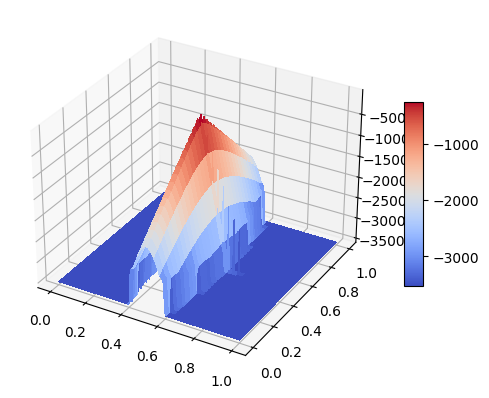

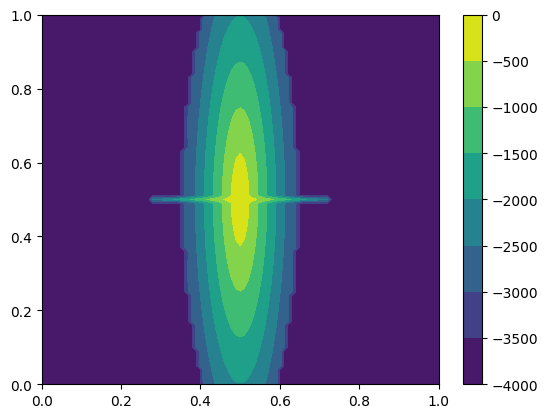

In [39]:
grid_x, grid_y, grid_vals = get_and_plot_bpe_over_grid(101)

In [40]:
np.save("grid_x.npy", grid_x)
np.save("grid_y.npy", grid_y)
np.save("grid_vals.npy", grid_vals)

In [41]:
grid_x.shape, grid_y.shape, grid_vals.shape

((10201, 1), (10201, 1), torch.Size([10201, 1]))

In [42]:
class BaseGPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
  num_outputs = 1

  def __init__(self, x, y, likelihood):
    super().__init__(x,y,likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=2))
    #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))
    # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel(ard_num_dims=2))


  def forward(self, x):
    return gpytorch.distributions.MultivariateNormal(mean=self.mean_module(x), covariance_matrix=self.covar_module(x))

In [43]:
def train_model(train_x, train_y, num_epochs=500, lr=0.01):
  noise = 0.0001
  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  model = BaseGPModel(train_x, train_y, likelihood)
  model.likelihood.noise = noise

  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  opt = torch.optim.Adam(model.parameters(), lr=lr)

  likelihood.train()
  model.train()

  losses = []

  for epoch in range(num_epochs):
    opt.zero_grad()
    pd = model(train_x)
    loss = -mll(pd, train_y)
    loss.backward()
    opt.step()
    losses.append(loss.detach().item())


  likelihood.eval()
  model.eval()
  mid = num_epochs//2
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(19, 8))
  ax0.plot(losses)
  ax1.plot(losses[mid:])
  print(f"Final MLL Loss: {losses[-1]}")
  return model, likelihood

In [44]:
def evaluate_GP_model(model, grid_x, grid_y, grid_vals):
  model.eval()
  model.likelihood.eval()

  test_x = np.concatenate([grid_x, grid_y], axis=-1)
  test_x = torch.from_numpy(test_x)
  with torch.inference_mode():
    f_preds = model(test_x)
    preds = f_preds.mean
  loss = torch.nn.functional.l1_loss(preds, grid_vals)
  print(f"MAE Loss: {loss.item()}")

  resolution = int(grid_vals.shape[0]**0.5)
  x1 = grid_x.reshape((resolution, resolution))
  y1 = grid_y.reshape((resolution, resolution))
  bpe_predicted = preds.reshape((resolution, resolution))

  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  surf = ax.plot_surface(x1, y1, bpe_predicted, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
  fig.colorbar(surf, shrink=0.5, aspect=10)
  plt.show()

  plt.figure()
  plt.contourf(x1, y1, bpe_predicted)
  plt.colorbar()
  plt.show()
  return loss.item()

In [45]:
sampler = qmc.Sobol(d=2)
xs = sampler.random(n=64)
ys = get_snd_outputs(xs)

xs = torch.tensor(xs)
ys = torch.tensor(ys).squeeze()

/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:253: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ef1f2 = (np.array(res[self.name+'_E']),
/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:254: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+'_f1']),
/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:255: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+f2key]))
/content/lcls_beamline_toolbox/lcls_beamline_toolbox/xraywavetrace/optics1d.py:7169: RuntimeWarning: invalid value encountered in scal

Final MLL Loss: 20756.7344919642


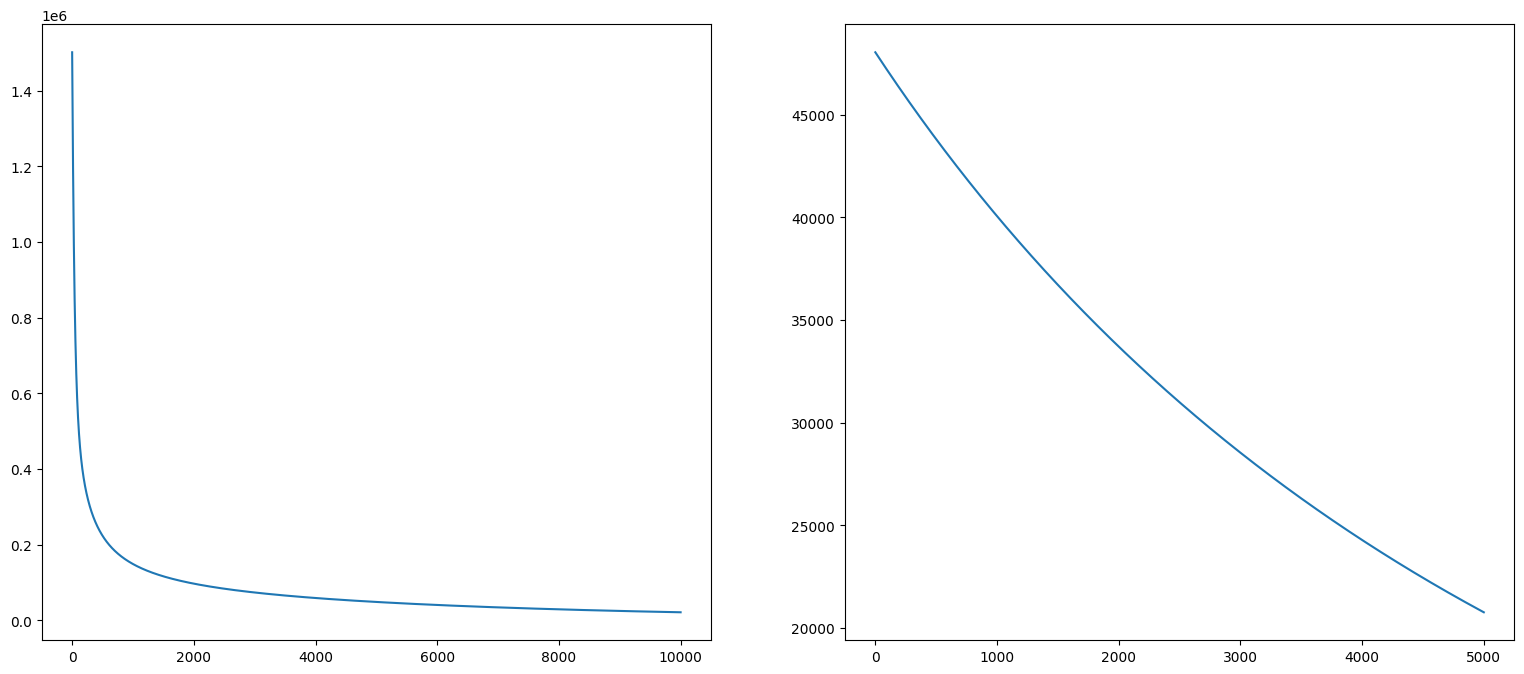

In [46]:
model, likelihood = train_model(xs, ys, num_epochs=10000)

<ipython-input-44-375864a46202>:10: UserWarning: Using a target size (torch.Size([10201, 1])) that is different to the input size (torch.Size([10201])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.l1_loss(preds, grid_vals)


MAE Loss: 687.9526001136035


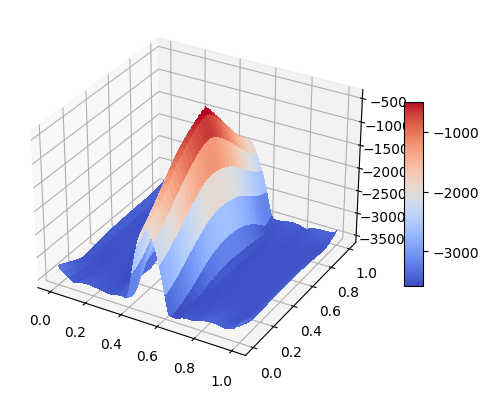

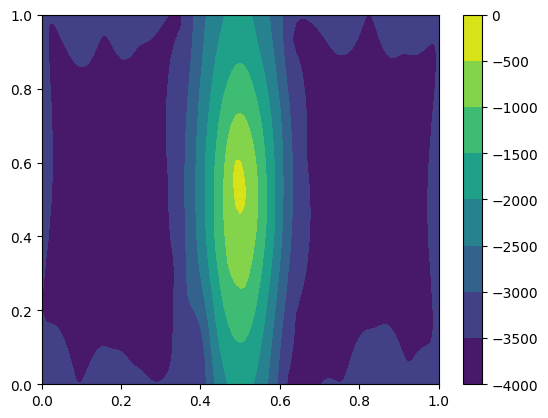

687.9526001136035

In [47]:
evaluate_GP_model(model, grid_x, grid_y, grid_vals)